## Clustering  

Exploratory clustering of T2D and lipids data. The goal of clustering is to determine whether there is a certain subset of points that are similar to each other - whether these splits are made between, across or within the trait labels. Clustering is highly dependent on the parameters chosen for distance measure and the number of desired clusters. Moreover, clustering is not guaranteed to produce useful results, depending on the structure of the data and on the definition of what a 'useful' cluster is. 

In [102]:
import pandas as pd
import numpy as np
import boto3
import s3fs
import os
import sys
import warnings
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy import stats
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')

import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator
from auth import access_key, secret_key

In [103]:
filepath = "s3://voightlab-data/"

In [104]:
grouped_df = pd.read_csv(filepath + "grouped/grouped.csv")
grouped_df.head()

,Unnamed: 0,snp,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,Chr1_Group_1,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,1,1,1,0.001173
1,1,Chr1_Group_10,1,0,1,1,0,1,0,1,...,0,0,0,0,0,1,0,1,0,0.014960
2,2,Chr1_Group_100,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,1,1,0.016427
3,3,Chr1_Group_1000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.007040
4,4,Chr1_Group_100046246,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.001173


In [105]:
# Remove snp since its a non numerical column - can be reattached later if we preserve order
X_train = grouped_df.loc[:, grouped_df.columns!='snp']

In [106]:
# Init class for plotting and model evaluation
ev = Evaluator()

### Subsampling

2749 features are far too many to cluster efficiently given that we would like to evaluate pairwise distances between samples to measure the relative effectiveness of clustering. In order to speed up runtime I'm loading in the features selected in the Feature Selection notebook based on the chi squared test for both t2d and lipids and randomly sampling from this featureset. 

In [107]:
t2d_mask = pd.read_csv(filepath + "t2d/FeatureSelected/chi2/X_train.csv", index_col=0)
lipids_mask = pd.read_csv(filepath + "lipids/FeatureSelected/chi2/X_train.csv", index_col=0)

In [108]:
num_features = 25
feature_list = list(t2d_mask.columns) + (list(lipids_mask.columns))
random.shuffle(feature_list)
features = feature_list[:num_features]

In [109]:
X_train = X_train.loc[:, features[:25]]
X_train.head()

,MAFB,NKX2.2,E118-H3K27ac.gappedPeak,HepG2_ChIP-seq_MYBL2_ENCFF002CKR.bed,E008-H3K79me2.gappedPeak,HepG2_ChIP-seq_TEAD4_ENCFF002CLG.bed,hepatocyte_p300_Rif.bed,GSE64233_p65_V_final.bed,snpcount,HepG2_ChIP-seq_CTCF_ENCFF002CDZ.bed,...,islet_pooled_H3K27ac.bed,hsap_HNF4A_hg19.bed,E004-H3K79me2.gappedPeak,PANC.ISLT-EnhA,GSM1208731_batch2_chrom1_LoVo_E2F8_PassedQC_peaks_hg19.bed,HepG2_ChIP-seq_ARID3A_ENCFF002CTS.bed,Islets.stretchEnhancers.bed,GSM1208788_batch2_chrom1_LoVo_RARG_PassedQC_peaks_hg19.bed,PANC.ISLT-EnhWk,FOXA2
0,0,0,1,0,0,0,0,0,0.001173,1,...,1,0,1,0,1,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0.014960,1,...,1,0,0,1,0,0,0,0,0,0
2,0,1,1,1,1,0,1,0,0.016427,0,...,1,1,1,0,1,1,0,1,1,0
3,0,0,0,0,0,0,0,0,0.007040,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0.001173,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# Some utility functions to help us compare clustering with a few different parameters
def concat_labels(df, labels):
    labeled_df = pd.concat([df, labels], axis=1)
    return labeled_df



def plot_compare(results, labels, xlabel, ylabel, titles, percentages=True):
    num_rows = int(len(results) / 2)
    num_cols = len(results) - num_rows

    if (num_rows != num_cols) or len(results) != len(titles):
        raise ValueError('Number of items in results should be even\
                             and equal to number of items in titles')

    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(13, 9), dpi=80)
    fig.subplots_adjust(hspace=0.5)
    idx=0

    for r_ind,row in enumerate(ax):
        for c_ind, col in enumerate(row):
            col.bar(range(len(results[idx])), [10 * stat for stat in results[idx]], align='center')
            col.set_title("\n" + titles[idx] + "\n")
            col.set_ylabel(ylabel)
            col.set_xticklabels(labels[idx])
            col.set_xticks(range(len(labels[idx])))
            col.set_yticklabels(round(10 * i, 3) for i in range(0, 11))
            col.set_yticks(range(11))

            for i, v in enumerate(results[idx]):
                if percentages:
                    col.text(i - 0.1, v*10 +0.2 , str(round(v * 100, 1)) + " %", color='white')
                else:
                    col.text(i - 0.1, v*10 + 0.2 , str(round(v, 2)) , color='white')
                    

            idx+=1

    plt.show()



def cluster_compare(n_clusters, model, data, metric):
    results = []
    labels = []
    
    for n in n_clusters:
        model.n_clusters=n
        model.fit(data)
        predictions = pd.Series(model.labels_, name='label')
        unique, counts = np.unique(predictions, return_counts=True)
        
        if 'label' in data.columns:
            data['label'] = predictions
        else:
            data = concat_labels(data, predictions)
        
        cluster_metrics = []
        
        for index,val in enumerate(unique):
            avg_dist = pairwise_distances(data.loc[data['label'] == val], metric=metric, n_jobs=-1).mean()
            cluster_metrics.append(avg_dist)
        
        cluster_labels = [str(val) for val in unique] 
        labels.append(cluster_labels)
        results.append(cluster_metrics)
            
    titles = [(str(n) + " Clusters\n" ) for n in n_clusters]
    plot_compare(results, labels, 'cluster number', 'avg  {} distance'.format(metric), titles, False)

### Agglomerative Clustering

A hierarchical clustering method with a bottom-up approach. Each observation starts in its own cluster and clusters are iteratively merged in a way to minimize some linkage criterion. 

In [111]:
agg_cluster = AgglomerativeClustering(n_clusters=3,
                                      affinity='l1',
                                      linkage='average')

In [112]:
agg_cluster.fit(X_train)

AgglomerativeClustering(affinity='l1', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=3, pooling_func='deprecated')

In [113]:
labels = agg_cluster.labels_
unique, counts = np.unique(labels, return_counts=True)
print (np.asarray((unique, counts)).T)

[[   0 1493]
 [   1 9025]
 [   2    3]]


In [114]:
print("Number of components: {}".format(agg_cluster.n_components_))
print("Number of leaves: {}".format(agg_cluster.n_leaves_))

Number of components: 1
Number of leaves: 10521


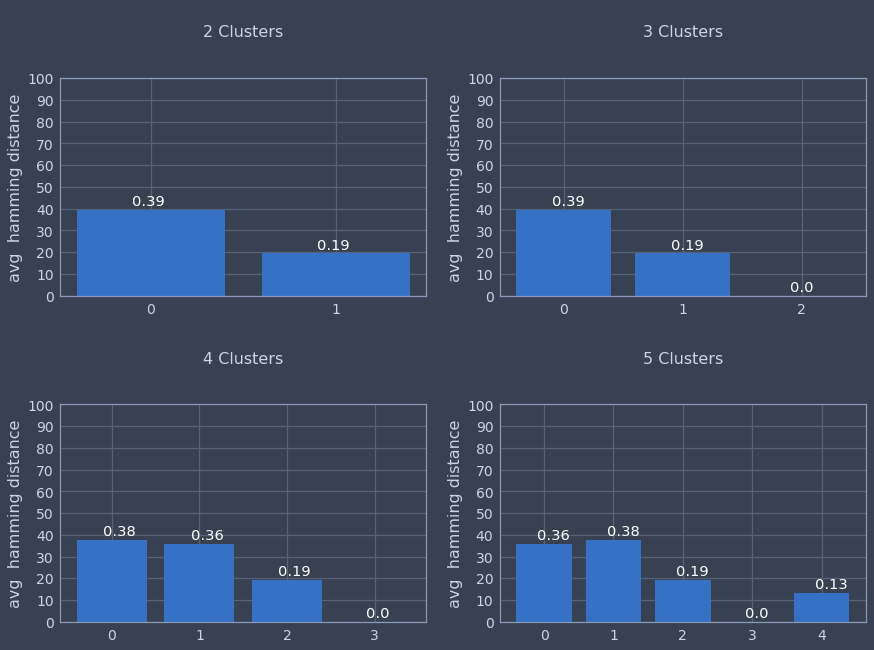

In [115]:
cluster_compare([2, 3, 4, 5], agg_cluster, X_train, 'hamming')